In [1]:
from google.colab import drive
drive.mount('/content/drive',force_remount=True)

Mounted at /content/drive


In [2]:
import os
import cv2
import numpy as np
import matplotlib.pyplot as plt
from tqdm.notebook import tqdm
import pandas as pd
from keras import models
from keras import layers
from sklearn.model_selection import train_test_split
from sklearn.metrics import f1_score, roc_curve, auc, precision_score, accuracy_score, confusion_matrix

In [3]:
def read_image(filepath):
    return cv2.imread(os.path.join(data_dir, filepath)) 

def resize_image(image, image_size):
    return cv2.resize(image.copy(), image_size, interpolation = cv2.INTER_AREA)

In [4]:
disease_types=['COVID', 'NonCOVID']
data_dir = '/content/drive/MyDrive/train'
train_dir = os.path.join(data_dir)

In [5]:
train_data = []
for defects_id, sp in enumerate(disease_types):
    for file in os.listdir(os.path.join(train_dir, sp)):
        train_data.append(['{}/{}'.format(sp, file), defects_id, sp])      
train = pd.DataFrame(train_data, columns=['File', 'DiseaseID','Disease Type'])

In [6]:
train.head(6000)

,File,DiseaseID,Disease Type
0,COVID/1.3.12.2.1107.5.1.4.78983.30000020032114...,0,COVID
1,COVID/1.3.12.2.1107.5.1.4.78983.30000020032114...,0,COVID
2,COVID/1.3.12.2.1107.5.1.4.78983.30000020032114...,0,COVID
3,COVID/1.3.12.2.1107.5.1.4.78983.30000020032114...,0,COVID
4,COVID/1.3.12.2.1107.5.1.4.78983.30000020032114...,0,COVID
...,...,...,...
5995,NonCOVID/1.3.12.2.1107.5.1.4.78983.30000020031...,1,NonCOVID
5996,NonCOVID/1.3.12.2.1107.5.1.4.78983.30000020031...,1,NonCOVID
5997,NonCOVID/1.3.12.2.1107.5.1.4.78983.30000020032...,1,NonCOVID
5998,NonCOVID/1.3.12.2.1107.5.1.4.78983.30000020032...,1,NonCOVID


In [7]:
IMAGE_SIZE = 75
X = np.zeros((train.shape[0], IMAGE_SIZE, IMAGE_SIZE, 3))
for i, file in tqdm(enumerate(train['File'].values), total = len(train)):
    image = read_image(file)
    if image is not None:
        X[i] = resize_image(image, (IMAGE_SIZE, IMAGE_SIZE))
X /= 255.        
y = train['DiseaseID'].values
print(X.shape)
print(y.shape)


(6769, 75, 75, 3)
(6769,)


In [8]:
x_train, x_test, y_train, y_test = train_test_split(X, y, test_size=0.2, stratify=y, random_state = 1)

In [10]:
from keras.applications.inception_resnet_v2 import InceptionResNetV2
conv_base = InceptionResNetV2(weights='imagenet',
                  include_top=False,
                  input_shape=(75, 75, 3))

219070464/219055592 [==============================] - 2s 0us/step


In [11]:
conv_base.summary()

Model: "inception_resnet_v2"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 75, 75, 3)]  0                                            
__________________________________________________________________________________________________
conv2d (Conv2D)                 (None, 37, 37, 32)   864         input_1[0][0]                    
__________________________________________________________________________________________________
batch_normalization (BatchNorma (None, 37, 37, 32)   96          conv2d[0][0]                     
__________________________________________________________________________________________________
activation (Activation)         (None, 37, 37, 32)   0           batch_normalization[0][0]        
________________________________________________________________________________

In [12]:
conv_base.trainable = True

In [13]:
model = models.Sequential()
model.add(conv_base)
model.add(layers.Flatten())
model.add(layers.Dense(128, activation='relu'))
model.add(layers.Dense(64, activation='relu'))
model.add(layers.Dense(32, activation='relu'))
model.add(layers.Dense(1, activation='sigmoid'))

In [14]:
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
inception_resnet_v2 (Functio (None, 1, 1, 1536)        54336736  
_________________________________________________________________
flatten (Flatten)            (None, 1536)              0         
_________________________________________________________________
dense (Dense)                (None, 128)               196736    
_________________________________________________________________
dense_1 (Dense)              (None, 64)                8256      
_________________________________________________________________
dense_2 (Dense)              (None, 32)                2080      
_________________________________________________________________
dense_3 (Dense)              (None, 1)                 33        
Total params: 54,543,841
Trainable params: 54,483,297
Non-trainable params: 60,544
_______________________________________

In [15]:
for layer in model.layers : 
  print(layer.name , '==>' , layer.trainable)

inception_resnet_v2 ==> True
flatten ==> True
dense ==> True
dense_1 ==> True
dense_2 ==> True
dense_3 ==> True


In [16]:
model.compile(optimizer='rmsprop', loss='binary_crossentropy', metrics=['accuracy'])

In [22]:
history = model.fit(x_train, y_train,
                    batch_size=64, epochs=30,steps_per_epoch=32,
                    verbose=1,validation_split=0.1)

Epoch 1/30
32/32 [==============================] - 7s 212ms/step - loss: 0.0218 - accuracy: 0.9932 - val_loss: 0.0754 - val_accuracy: 0.9834
Epoch 2/30
32/32 [==============================] - 6s 203ms/step - loss: 0.0238 - accuracy: 0.9937 - val_loss: 0.1166 - val_accuracy: 0.9723
Epoch 3/30
32/32 [==============================] - 6s 200ms/step - loss: 0.0272 - accuracy: 0.9910 - val_loss: 0.1849 - val_accuracy: 0.9594
Epoch 4/30
32/32 [==============================] - 7s 205ms/step - loss: 0.0272 - accuracy: 0.9941 - val_loss: 0.1203 - val_accuracy: 0.9834
Epoch 5/30
32/32 [==============================] - 6s 201ms/step - loss: 0.0248 - accuracy: 0.9925 - val_loss: 0.3083 - val_accuracy: 0.9502
Epoch 6/30
32/32 [==============================] - 7s 208ms/step - loss: 9.2688e-04 - accuracy: 1.0000 - val_loss: 0.0574 - val_accuracy: 0.9889
Epoch 7/30
32/32 [==============================] - 7s 210ms/step - loss: 0.0216 - accuracy: 0.9927 - val_loss: 0.0571 - val_accuracy: 0.9852
Ep

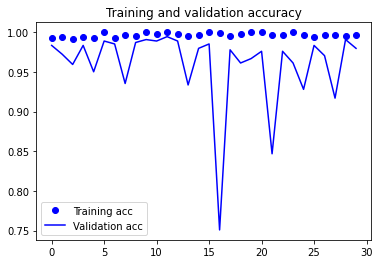

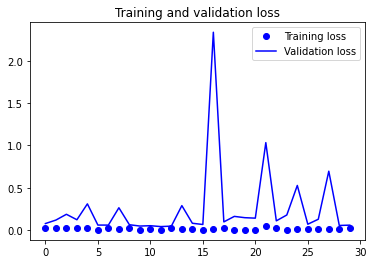

In [23]:
import matplotlib.pyplot as plt
%matplotlib inline
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']
loss = history.history['loss']
val_loss = history.history['val_loss']

epochs = range(len(acc))

plt.plot(epochs, acc, 'bo', label='Training acc')
plt.plot(epochs, val_acc, 'b', label='Validation acc')
plt.title('Training and validation accuracy')
plt.legend()

plt.figure()

plt.plot(epochs, loss, 'bo', label='Training loss')
plt.plot(epochs, val_loss, 'b', label='Validation loss')
plt.title('Training and validation loss')
plt.legend()

In [24]:
y_pred = model.predict_classes(x_test)

/usr/local/lib/python3.7/dist-packages/keras/engine/sequential.py:450: UserWarning: `model.predict_classes()` is deprecated and will be removed after 2021-01-01. Please use instead:* `np.argmax(model.predict(x), axis=-1)`,   if your model does multi-class classification   (e.g. if it uses a `softmax` last-layer activation).* `(model.predict(x) > 0.5).astype("int32")`,   if your model does binary classification   (e.g. if it uses a `sigmoid` last-layer activation).
  warnings.warn('`model.predict_classes()` is deprecated and '


In [25]:
tn, fp, fn, tp = confusion_matrix(y_test, y_pred).ravel()

In [26]:
sp = tn/(tn+fp)
sn = tp/(tp+fn)

print('f1 score =  %.3f'%f1_score(y_test, y_pred))
print('Precision =  %.3f'%precision_score(y_test, y_pred))
print('Test accuracy =  %.3f'%accuracy_score(y_test, y_pred))
print('Specificity =  %.3f'%sp)
print('Sensitivity =  %.3f'%sn)

f1 score =  0.970
Precision =  0.992
Test accuracy =  0.970
Specificity =  0.993
Sensitivity =  0.948
